In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import shutil
from IPython import display
import os

import meep as mp

import sys
sys.path.append('../../lib')
from ataitmeep import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from make_tomeep import give_geom
give_geom()

layer 1 not in meep mapping
layer 2 not in meep mapping


(Vector3<31.0, 15.0, 0.0>,
  <meep.geom.Prism at 0x1143eeba8>])

In [3]:
# Define the system
resolution = 20 # pixels/um

dpml = 1

lcen = 1.22
fcen = 1/lcen
df = 0.5*fcen

# Load it
cell, geometry = give_geom()

sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                                  size=mp.Vector3(0, .35),
                                  center=mp.Vector3(-cell.x/2+dpml, 0),
                                  eig_match_freq=True)]
# sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df), 
#                      component=mp.Ez,
#                      center=mp.Vector3(-cell.x/2+dpml, 0),
#                      size=mp.Vector3(0, .35))]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell,
                    boundary_layers=[mp.PML(dpml)],
                    sources=sources,
                    geometry=geometry,
#                     symmetries=[mp.Mirror(mp.Y, phase=1)],
                   )

# p1_region = mp.FluxRegion(volume=p1)
# flux1 = sim.add_flux(fcen,0,1,p1_region)

layer 1 not in meep mapping
layer 2 not in meep mapping


-----------
Initializing structure...
run 0 finished at t = 0.0 (0 timesteps)


Vector3<30.0, 18.0, 0.0>

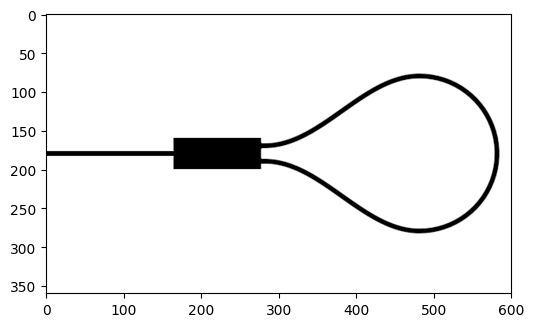

In [55]:
show_geometry(sim)
cell

In [ ]:
def livefield(sim):
    liveplot(sim, mp.Ez)
def plot_sim(until=200):
    sim.reset_meep()
    shutil.rmtree('outputs', ignore_errors=True)
    sim.use_output_directory('outputs')
    sim.run(
            mp.at_beginning(livefield),
            mp.at_every(5, livefield),
#             mp.at_every(1, mp.output_png(mp.Ey, "-Zc dkbluered")),
#             mp.to_appended("ez", mp.at_every(0.6, mp.output_efield_z)),
            until=until)
    # now make the gif
#     subprocess.check_call(['convert', 'outputs/ey-*.png', 'ey.gif'])
#     subprocess.check_call(['open', '-a', 'Safari', 'ey.gif'])

plt.figure(figsize=(15, 8))
plot_sim(300)

field decay(t = 200.10000000000002): 2.6054372263916056e-15 / 0.028543400740641798 = 9.127984608651865e-14
run 0 finished at t = 200.10000000000002 (8004 timesteps)


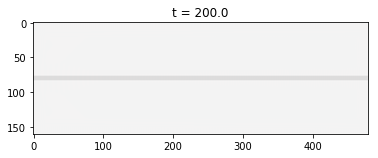

In [17]:
# Ok first do the straight waveguide
def do_baseline():
    
    straight_geometry = [background,
                        mp.Block(mp.Vector3(cell.x, sm_width, 1e20),
                                 center=mp.Vector3(0, 0),
                                 material=mp.Medium(epsilon=12))]
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=straight_geometry,
                        sources=sources,
                        resolution=resolution,
                        symmetries=[mp.Mirror(mp.Y, phase=-1)],
                        progress_interval=1e6)
    sim.reset_meep()

    # Now put in some flux monitors. Make sure the pulse source was selected
    # reflected flux
    refl_fr = mp.FluxRegion(center=mp.Vector3(-cell.x / 2 + dpml + .5,0,0), size=mp.Vector3(0,2*sm_width,0))                            
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    # transmitted flux
    tran_fr = mp.FluxRegion(center=mp.Vector3(cell.x / 2 - dpml, 0,0), size=mp.Vector3(0,2*sm_width,0))
    tran = sim.add_flux(fcen, df, nfreq, tran_fr)

    # Do it
    monitor_pt = mp.Vector3(cell.x/2-dpml-0.5,0)
    sim.run(mp.at_beginning(livefield),
            mp.at_every(5, livefield),    
            until_after_sources=mp.stop_when_fields_decayed(50,mp.Ey, monitor_pt,1e-3))

    # for normalization run, save flux fields data for reflection plane
    straight_refl_data = sim.get_flux_data(refl)
    # transmission flux. Note this is entirely different purpose than the above line
    # This one is to normalize power. the other was to negate forward-propagating wave
    straight_tran_flux = mp.get_fluxes(tran)
    return straight_refl_data, straight_tran_flux

straight_refl_data, straight_tran_flux = do_baseline()  # comment this when you dont need to do it again

field decay(t = 250.125): 1.215897422275955e-07 / 0.02757244207239638 = 4.40982854940233e-06
run 0 finished at t = 250.125 (10005 timesteps)


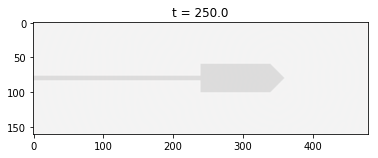

In [25]:
def do_trial(straight_refl_data, with_geometry=geometry, do_live=True):
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=with_geometry,
                        sources=sources,
                        resolution=resolution,
                        symmetries=[mp.Mirror(mp.Y, phase=-1)],
#                         progress_interval=1e6,
                       )
    sim.reset_meep()
    # reflected flux
    refl_fr = mp.FluxRegion(center=mp.Vector3(-cell.x / 2 + dpml + .5,0,0), size=mp.Vector3(0,2*sm_width,0))                            
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)
    # for normal run, load negated fields to subtract incident from refl. fields
    sim.load_minus_flux_data(refl, straight_refl_data)

    monitor_pt = mp.Vector3(0,0)
    run_args = (mp.at_beginning(livefield), mp.at_every(5, livefield),) if do_live else tuple()
    sim.run(*run_args,    
            until_after_sources=mp.stop_when_fields_decayed(50,mp.Ey, monitor_pt,1e-3))
    return refl

refl = do_trial(straight_refl_data, with_geometry=give_geometry(MMI_length=5))
bend_refl_flux = np.array(mp.get_fluxes(refl))
flux_freqs = np.array(mp.get_flux_freqs(refl))

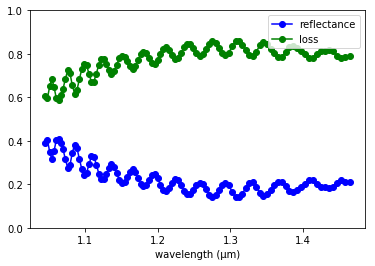

In [26]:
wl = 1 / flux_freqs
Rs = -bend_refl_flux/np.array(straight_tran_flux)
plt.plot(wl,Rs,'bo-',label='reflectance')
plt.plot(wl,1-Rs,'go-',label='loss')
# plt.axis([1.0, 1.44, 0, 1])
plt.ylim([0,1])
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")


In [28]:
spectra = []
L_vals = np.linspace(3, 6, 20)
theta_vals = np.linspace(80, 100, 10)
W_vals = np.linspace(2, 2.1, 3)
param_vals = L_vals

for p in param_vals:
    refl = do_trial(straight_refl_data, 
                    with_geometry=give_geometry(MMI_length=p), 
                    do_live=False)
    bend_refl_flux = np.array(mp.get_fluxes(refl))
    Rs = -bend_refl_flux/straight_tran_flux
    spectra.append(Rs)
    

-----------
Initializing structure...
field decay(t = 50.025000000000006): 9.226701047918675e-08 / 9.226701047918675e-08 = 1.0
field decay(t = 100.05000000000001): 0.02757000553038218 / 0.02757000553038218 = 1.0
field decay(t = 150.07500000000002): 0.0004933608248638819 / 0.02757000553038218 = 0.017894839532048613
field decay(t = 200.10000000000002): 1.4607691339606481e-08 / 0.02757000553038218 = 5.298399858320227e-07
run 0 finished at t = 200.10000000000002 (8004 timesteps)
-----------
Initializing structure...
field decay(t = 50.025000000000006): 9.22525933671065e-08 / 9.22525933671065e-08 = 1.0
field decay(t = 100.05000000000001): 0.027572559419256057 / 0.027572559419256057 = 1.0
field decay(t = 150.07500000000002): 0.001253747046185072 / 0.027572559419256057 = 0.045470825798981984
field decay(t = 200.10000000000002): 1.4058797506065216e-08 / 0.027572559419256057 = 5.098836597754094e-07
run 0 finished at t = 200.10000000000002 (8004 timesteps)
-----------
Initializing structure...
f

field decay(t = 150.07500000000002): 0.003402900924021762 / 0.027572448736731297 = 0.12341671051829742
field decay(t = 200.10000000000002): 1.854178558676309e-05 / 0.027572448736731297 = 0.0006724751132481826
run 0 finished at t = 200.10000000000002 (8004 timesteps)
-----------
Initializing structure...
field decay(t = 50.025000000000006): 9.225169965196834e-08 / 9.225169965196834e-08 = 1.0
field decay(t = 100.05000000000001): 0.02757245420032641 / 0.02757245420032641 = 1.0
field decay(t = 150.07500000000002): 0.003522255558529289 / 0.02757245420032641 = 0.1277454496048303
field decay(t = 200.10000000000002): 2.2789683258792123e-05 / 0.02757245420032641 = 0.000826538076488031
run 0 finished at t = 200.10000000000002 (8004 timesteps)
-----------
Initializing structure...
field decay(t = 50.025000000000006): 9.225169979847857e-08 / 9.225169979847857e-08 = 1.0
field decay(t = 100.05000000000001): 0.027572449808919222 / 0.027572449808919222 = 1.0
field decay(t = 150.07500000000002): 0.0041

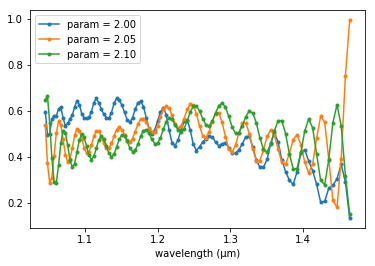

In [137]:
wl = 1 / flux_freqs
for iV, p in enumerate(param_vals):
    plt.plot(wl, (spectra[iV]), '.-', label='param = {:.2f}'.format(p))
plt.xlabel("wavelength (μm)")
# plt.ylim([0, 1])
plt.legend()